#### Задача:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
**Price**

Метрика качества:
**R2** - коэффициент детерминации (sklearn.metrics.r2_score)

#### Описание датасета:

* **Id** - идентификационный номер квартиры.
* **DistrictId** - идентификационный номер района.
* **Rooms** - количество комнат Square - площадь.
* **LifeSquare** - жилая площадь.
* **KitchenSquare** - площадь кухни.
* **Floor** - этаж.
* **HouseFloor** - количество этажей в доме.
* **HouseYear** - год постройки дома.
* **Ecology_1**, **Ecology_2**, **Ecology_3** - экологические показатели местности.
* **Social_1**, **Social_2**, **Social_3** - социальные показатели местности.
* **Healthcare_1**, **Helthcare_2** - показатели местности, связанные с охраной здоровья.
* **Shops_1**, **Shops_2** - показатели, связанные с наличием магазинов, торговых центров.
* **Price** - цена квартиры.

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
%matplotlib inline

#%config InlineBackend.figure_formats=['png']

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
plt.style.use('seaborn-ticks')
#plt.style.use('seaborn-whitegrid')
#plt.rcParams['figure.figsize'] = (6, 4)
matplotlib.rcParams.update({'font.size': 14})

In [4]:
#%%javascript
#IPython.OutputArea.prototype._should_scroll = function(lines) {
#    return false;
#}

In [5]:
DATASET_PATH = './train.csv'
TEST_PATH = './test.csv'

In [6]:
pd.options.display.max_rows=9999
pd.options.display.max_columns = 50

In [7]:
def sep():
        print('=========')

class DataPre:

    disp_all=False

    def __init__(self,train,test,target_name):
        self.train=train
        self.test=test
        self.target_name = target_name
        self.target=train[self.target_name]
        self.preds_index=test.index
        self.dfs=[self.train,self.test]
        self.df_union=pd.concat((self.train.drop(self.target_name,axis=1), self.test))
#        self.colums_maps={}
        self.indexs={}

    def __getitem__(self, key):
        return self.dfs[key]

    def add_colums_map(self,col_names,bin_maps):
        for name in col_names:
#            self.colums_maps[name]=params
            self.prep_map_col(name,bin_maps[0])

    def prep_map_col(self,feature_bin_name,bin_map):
        self.train[feature_bin_name]=self.train[feature_bin_name].map(bin_map)
        display(self.train[feature_bin_name].value_counts())
        sep()
        self.test[feature_bin_name]=self.test[feature_bin_name].map(bin_map)
        display(self.test[feature_bin_name].value_counts())

    def show_info(self):
        display(self.train.info())
        display(self.test.info())
        print('==is NaN==')
        self.isna()
        print(f'{self.train.shape[0]}/{self.train.shape[1]} train row/col in dataset')
        print(f'{self.test.shape[0]}/{self.test.shape[1]} test row/col in dataset')   

    def show_desc(self,cols=False):
        if cols:
            display(self.train[cols].describe().T)
            display(self.test[cols].describe().T)
        else:
            display(self.train.describe().T)
            display(self.test.describe().T)

    def isna(self,col=False):
        if(col):
            self.train[self.train[col].isna()]
            sep()
            self.test[self.test[col].isna()]
        else:
            display(self.train.isna().sum()[self.train.isna().sum()>0])
            sep()
            display(self.test.isna().sum()[self.test.isna().sum()>0])

    def show_obj(self):
        def show(df):
            listOfColumnNames=self.find_obj(df)
            if(listOfColumnNames):
                display(df.describe(include='object'))
                print('object list:',listOfColumnNames)
                for col in listOfColumnNames:
                    display(df[col].value_counts())
                    sep()
            else:
                print('object not find')
        show(self.train)
        show(self.test)

    def find_obj(self,df):
        filteredColumns=df.dtypes[df.dtypes==np.object]
        listOfColumnNames=list(filteredColumns.index)
        return listOfColumnNames

    def d(self,i,train,test,all=disp_all):
            self.indexs[i]={}
            self.indexs[i]['train']=train.index
            self.indexs[i]['test']=test.index
            display(train.shape)
            display(test.shape)
            if all:
                display(train)
                display(test)
            else:
                display(train.head(2))
                display(test.head(2))
            
            
    def h(self,i,all=disp_all):
        display(self.train[self.train.index.isin(self.indexs[i]['train'])].shape)
        display(self.test[self.test.index.isin(self.indexs[i]['test'])].shape)
        if all:
            display(self.train[self.train.index.isin(self.indexs[i]['train'])])
            display(self.test[self.test.index.isin(self.indexs[i]['test'])])
        else:
            display(self.train[self.train.index.isin(self.indexs[i]['train'])].head(2))
            display(self.test[self.test.index.isin(self.indexs[i]['test'])].head(2))

    def uniq(self,col,sort=True):
        train=set(self.train[col].unique())
        test=set(self.test[col].unique())
        all=train|test
        dif=test-train
        if sort:
            print(f'{sorted(all)}\nnot in train:\n{sorted(dif)}')
        else:
            print(f'{all}\nnot in train:\n{dif}')

    def ctn(self, col, sort = True, all = True):
        if all:
            if sort:
                display(self.df_union[col].value_counts().sort_values())
            else:
                display(self.df_union[col].value_counts())
        else:
            if sort:
                display(self.train[col].value_counts().rename_axis('MyIdx').sort_values(by = [col, 'MyIdx']))
                display(self.test[col].value_counts().rename_axis('MyIdx').sort_values(by = [col, 'MyIdx']))
            else:
                display(self.train[col].value_counts())
                display(self.test[col].value_counts())

    '''можно использовать для ускорения написания кода и минимизирования опечаток, но пока обойдемся без exec =_=
    def dx(self,str_ex,all=disp_all):
        #Cls.x(1,"Cls.train.loc[(Cls.train['Square']-Cls.train['KitchenSquare']<8)&(Cls.train['Square']>10)]")
        train=exec(str_ex)
        test=exec(str_ex.replace('train','test'))
        self.indexs[i]={}
        self.indexs[i]['train']=train.index
        self.indexs[i]['test']=test.index
        display(train.shape)
        display(test.shape)
        if all:
            display(train)
            display(test)
        else:
            display(train.head(2))
            display(test.head(2))'''

In [8]:
def ax1(row,col,val,gr_by='Square'):
    start=0.9
    end=1.1
    n=1
    for i in range(n):
#        med=Cls.df_union.loc[(Cls.df_union[gr_by]<row[gr_by]*end)&(Cls.df_union[gr_by]>row[gr_by]*start)&(Cls.df_union[col]>val),col].median()
        med=Cls.train.loc[(Cls.train[gr_by]<row[gr_by]*end)&(Cls.train[gr_by]>row[gr_by]*start)&(Cls.train[col]>val),col].median()
        if np.isnan(med):
            start-=0.05
            end+=0.05
        else:
            if(i):
                print (f'range changed: {start:.2f} - {end:.2f}')
            return med
    else:
        print('not found median. index:',row.name)
        return row[col]

#### Чтение данных

In [9]:
train_df=pd.read_csv(DATASET_PATH, index_col='Id')
test_df=pd.read_csv(TEST_PATH, index_col='Id')
Cls=DataPre(train_df,test_df,['Price'])
display(Cls.train.head(1))
display(Cls.test.head(1))

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.08904,B,B,33,7976,5,NaN,0,11,B,184966.93073


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B


In [10]:
Cls.show_info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     10000 non-null  int64  
 1   Rooms          10000 non-null  float64
 2   Square         10000 non-null  float64
 3   LifeSquare     7887 non-null   float64
 4   KitchenSquare  10000 non-null  float64
 5   Floor          10000 non-null  int64  
 6   HouseFloor     10000 non-null  float64
 7   HouseYear      10000 non-null  int64  
 8   Ecology_1      10000 non-null  float64
 9   Ecology_2      10000 non-null  object 
 10  Ecology_3      10000 non-null  object 
 11  Social_1       10000 non-null  int64  
 12  Social_2       10000 non-null  int64  
 13  Social_3       10000 non-null  int64  
 14  Healthcare_1   5202 non-null   float64
 15  Helthcare_2    10000 non-null  int64  
 16  Shops_1        10000 non-null  int64  
 17  Shops_2        10000 non-null  object 
 18  Pri

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 725 to 12504
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     5000 non-null   int64  
 1   Rooms          5000 non-null   float64
 2   Square         5000 non-null   float64
 3   LifeSquare     3959 non-null   float64
 4   KitchenSquare  5000 non-null   float64
 5   Floor          5000 non-null   int64  
 6   HouseFloor     5000 non-null   float64
 7   HouseYear      5000 non-null   int64  
 8   Ecology_1      5000 non-null   float64
 9   Ecology_2      5000 non-null   object 
 10  Ecology_3      5000 non-null   object 
 11  Social_1       5000 non-null   int64  
 12  Social_2       5000 non-null   int64  
 13  Social_3       5000 non-null   int64  
 14  Healthcare_1   2623 non-null   float64
 15  Helthcare_2    5000 non-null   int64  
 16  Shops_1        5000 non-null   int64  
 17  Shops_2        5000 non-null   object 
dtypes: fl

None

==is NaN==


LifeSquare      2113
Healthcare_1    4798
dtype: int64

LifeSquare      1041
Healthcare_1    2377
dtype: int64

10000/19 train row/col in dataset
5000/18 test row/col in dataset


### Обработка категориальных признаков

In [11]:
Cls.show_obj()

,Ecology_2,Ecology_3,Shops_2
count,10000,10000,10000
unique,2,2,2
top,B,B,B
freq,9903,9725,9175


object list: ['Ecology_2', 'Ecology_3', 'Shops_2']


B    9903
A      97
Name: Ecology_2, dtype: int64

B    9725
A     275
Name: Ecology_3, dtype: int64

B    9175
A     825
Name: Shops_2, dtype: int64

,Ecology_2,Ecology_3,Shops_2
count,5000,5000,5000
unique,2,2,2
top,B,B,B
freq,4952,4851,4588


object list: ['Ecology_2', 'Ecology_3', 'Shops_2']


B    4952
A      48
Name: Ecology_2, dtype: int64

B    4851
A     149
Name: Ecology_3, dtype: int64

B    4588
A     412
Name: Shops_2, dtype: int64

In [12]:
Cls.add_colums_map(['Ecology_2', 'Ecology_3', 'Shops_2'],[{
    'A': 1,
    'B': 0,
}])

0    9903
1      97
Name: Ecology_2, dtype: int64

0    4952
1      48
Name: Ecology_2, dtype: int64

0    9725
1     275
Name: Ecology_3, dtype: int64

0    4851
1     149
Name: Ecology_3, dtype: int64

0    9175
1     825
Name: Shops_2, dtype: int64

0    4588
1     412
Name: Shops_2, dtype: int64

In [13]:
Cls.show_desc()

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315775,21.058732,1.136859,41.774881,52.513310,65.900625,6.410652e+02
LifeSquare,7887.0,37.199645,86.241209,0.370619,22.769832,32.781260,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218671e-01
Ecology_2,10000.0,0.009700,0.098015,0.000000,0.000000,0.000000,0.000000,1.000000e+00


,count,mean,std,min,25%,50%,75%,max
DistrictId,5000.0,51.279200,44.179466,0.000000,21.000000,37.000000,77.000000,212.000000
Rooms,5000.0,1.910000,0.838594,0.000000,1.000000,2.000000,2.000000,17.000000
Square,5000.0,56.449500,19.092787,1.378543,41.906231,52.921340,66.285129,223.453689
LifeSquare,3959.0,36.158810,17.825287,0.333490,23.092026,32.925087,45.174091,303.071094
KitchenSquare,5000.0,5.976800,9.950018,0.000000,1.000000,6.000000,9.000000,620.000000
Floor,5000.0,8.632000,5.483228,1.000000,4.000000,7.000000,12.000000,78.000000
HouseFloor,5000.0,12.601000,6.789213,0.000000,9.000000,12.000000,17.000000,99.000000
HouseYear,5000.0,1984.392600,18.573149,1908.000000,1973.000000,1977.000000,2000.000000,2020.000000
Ecology_1,5000.0,0.119874,0.120070,0.000000,0.019509,0.072158,0.195781,0.521867
Ecology_2,5000.0,0.009600,0.097518,0.000000,0.000000,0.000000,0.000000,1.000000


### исправление ошибочных данных и выбросов

In [14]:
Cls.train[Cls.train['HouseYear']>2020]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,0,0,30,6141,10,262.0,3,6,0,254084.534396
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,0,0,25,4756,16,2857.0,5,8,0,243028.603096


явно ошибка ручного ввода, исправляем

In [15]:
Cls.train.loc[10814,'HouseYear']=2005
Cls.train.loc[11607,'HouseYear']=1968

In [16]:
Cls.d(1,Cls.train.loc[(Cls.train['Square']-Cls.train['KitchenSquare']<8)&(Cls.train['Square']>10)],
     Cls.test.loc[(Cls.test['Square']-Cls.test['KitchenSquare']<8)&(Cls.test['Square']>10)])

(32, 19)

(13, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,0,0,39,10418,9,900.0,1,9,0,370148.625285
1315,6,1.0,48.128114,45.023531,48.0,21,1.0,2013,0.243205,0,0,5,1564,0,540.0,0,0,0,146950.912410


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,0,0,30,7538,87,4702.0,5,5,0
5428,27,2.0,62.326044,NaN,61.0,12,17.0,1977,0.072158,0,0,2,629,1,NaN,0,0,1


In [17]:
Cls.d(2,Cls.train.loc[(Cls.train['Square']-Cls.train['KitchenSquare']<8)&(Cls.train['Square']>10)&(Cls.train['Square']<Cls.train['LifeSquare'])],
     Cls.test.loc[(Cls.test['Square']-Cls.test['KitchenSquare']<8)&(Cls.test['Square']>10)&(Cls.test['Square']<Cls.test['LifeSquare'])])

(7, 19)

(4, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
12390,72,3.0,97.490674,99.323558,96.0,22,25.0,2019,0.210473,0,0,11,2398,2,1994.0,3,0,0,445074.956552
16781,27,1.0,36.138409,36.710539,36.0,19,19.0,2017,0.072158,0,0,2,629,1,NaN,0,0,1,131742.536281


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,0,0,30,7538,87,4702.0,5,5,0
3341,62,3.0,112.114019,112.247841,112.0,3,3.0,2017,0.072158,0,0,2,629,1,NaN,0,0,1


общая пложадь меньше жилой в данных где площадь кухни явно завышена, меняем местами

In [18]:
Cls.train.loc[(Cls.train['Square']-Cls.train['KitchenSquare']<8)&(Cls.train['Square']>10)&(Cls.train['Square']<Cls.train['LifeSquare']),['Square','LifeSquare']]=Cls.train.loc[(Cls.train['Square']-Cls.train['KitchenSquare']<8)&(Cls.train['Square']>10)&(Cls.train['Square']<Cls.train['LifeSquare']),['LifeSquare','Square']].values
Cls.test.loc[(Cls.test['Square']-Cls.test['KitchenSquare']<8)&(Cls.test['Square']>10)&(Cls.test['Square']<Cls.test['LifeSquare']),['Square','LifeSquare']]=Cls.test.loc[(Cls.test['Square']-Cls.test['KitchenSquare']<8)&(Cls.test['Square']>10)&(Cls.test['Square']<Cls.test['LifeSquare']),['LifeSquare','Square']].values

In [19]:
Cls.h(2)

(7, 19)

(4, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
12390,72,3.0,99.323558,97.490674,96.0,22,25.0,2019,0.210473,0,0,11,2398,2,1994.0,3,0,0,445074.956552
16781,27,1.0,36.710539,36.138409,36.0,19,19.0,2017,0.072158,0,0,2,629,1,NaN,0,0,1,131742.536281


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
5480,190,1.0,15.948246,13.597819,12.0,2,5.0,1909,0.000000,0,0,30,7538,87,4702.0,5,5,0
3341,62,3.0,112.247841,112.114019,112.0,3,3.0,2017,0.072158,0,0,2,629,1,NaN,0,0,1


заменяем медианой площадь кухни где она завышена, разделяя кв по общей площади +- 10% (поиграться)

In [20]:
Cls.train.loc[(Cls.train['Square']-Cls.train['KitchenSquare']<8)&(Cls.train['Square']>10),'KitchenSquare']=Cls.train.loc[(Cls.train['Square']-Cls.train['KitchenSquare']<8)&(Cls.train['Square']>10)].apply(ax1,args=('KitchenSquare',1), axis=1)
Cls.test.loc[(Cls.test['Square']-Cls.test['KitchenSquare']<8)&(Cls.test['Square']>10),'KitchenSquare']=Cls.test.loc[(Cls.test['Square']-Cls.test['KitchenSquare']<8)&(Cls.test['Square']>10)].apply(ax1,args=('KitchenSquare',1), axis=1)

In [21]:
Cls.h(1)

(32, 19)

(13, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
16395,2,3.0,79.722243,44.731219,10.0,12,16.0,1987,0.130618,0,0,39,10418,9,900.0,1,9,0,370148.625285
1315,6,1.0,48.128114,45.023531,6.0,21,1.0,2013,0.243205,0,0,5,1564,0,540.0,0,0,0,146950.912410


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
5480,190,1.0,15.948246,13.597819,8.0,2,5.0,1909,0.000000,0,0,30,7538,87,4702.0,5,5,0
5428,27,2.0,62.326044,NaN,8.0,12,17.0,1977,0.072158,0,0,2,629,1,NaN,0,0,1


уменьшаем жилую площадь, где она завышена

In [22]:
Cls.d(1,Cls.train[(Cls.train['Square']-Cls.train['LifeSquare']<-5)&(Cls.train['LifeSquare']>100)],
     Cls.test[(Cls.test['Square']-Cls.test['LifeSquare']<-5)&(Cls.test['LifeSquare']>100)])

(4, 19)

(1, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14990,23,2.0,48.449873,263.542020,5.0,6,5.0,1972,0.075779,0,0,6,1437,3,NaN,0,2,0,141780.231857
16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,0,0,2,469,0,NaN,0,0,0,217357.492366


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
11533,94,2.0,48.713443,303.071094,6.0,5,12.0,1974,0.521867,0,0,25,6149,0,NaN,0,0,0


In [23]:
Cls.train.loc[(Cls.train['Square']-Cls.train['LifeSquare']<-5)&(Cls.train['LifeSquare']>1000),'LifeSquare']=Cls.train.loc[(Cls.train['Square']-Cls.train['LifeSquare']<-5)&(Cls.train['LifeSquare']>1000),'LifeSquare']/100
Cls.train.loc[(Cls.train['Square']-Cls.train['LifeSquare']<-5)&(Cls.train['LifeSquare']>100),'LifeSquare']=Cls.train.loc[(Cls.train['Square']-Cls.train['LifeSquare']<-5)&(Cls.train['LifeSquare']>100),'LifeSquare']/10
Cls.test.loc[(Cls.test['Square']-Cls.test['LifeSquare']<-5)&(Cls.test['LifeSquare']>1000),'LifeSquare']=Cls.test.loc[(Cls.test['Square']-Cls.test['LifeSquare']<-5)&(Cls.test['LifeSquare']>1000),'LifeSquare']/100
Cls.test.loc[(Cls.test['Square']-Cls.test['LifeSquare']<-5)&(Cls.test['LifeSquare']>100),'LifeSquare']=Cls.test.loc[(Cls.test['Square']-Cls.test['LifeSquare']<-5)&(Cls.test['LifeSquare']>100),'LifeSquare']/10

In [24]:
Cls.h(1)

(4, 19)

(1, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
14990,23,2.0,48.449873,26.354202,5.0,6,5.0,1972,0.075779,0,0,6,1437,3,NaN,0,2,0,141780.231857
16550,27,3.0,81.694417,74.805921,1.0,9,17.0,2016,0.017647,0,0,2,469,0,NaN,0,0,0,217357.492366


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
11533,94,2.0,48.713443,30.307109,6.0,5,12.0,1974,0.521867,0,0,25,6149,0,NaN,0,0,0


общая и жилая занижена, сначала меняем местами общая<жилой, потом увеличиваем в 10 раз

In [25]:
Cls.d(1,Cls.train[(Cls.train['Square']<10)&(Cls.train['LifeSquare']<10)],
     Cls.test[(Cls.test['Square']<10)&(Cls.test['LifeSquare']<10)])

(9, 19)

(7, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,0,0,4,915,0,NaN,0,0,0,107604.269441
10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,0,0,5,1564,0,540.0,0,0,0,137597.601458


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
9011,53,1.0,1.378543,1.353573,1.0,1,1.0,1977,0.049637,0,0,34,7759,0,229.0,1,3,0
16401,30,1.0,2.645046,4.338755,1.0,2,1.0,1977,0.000078,0,0,22,6398,141,1046.0,3,23,0


In [26]:
Cls.d(2,Cls.train[(Cls.train['Square']<10)&(Cls.train['LifeSquare']<10)&(Cls.train['Square']<Cls.train['LifeSquare'])],
     Cls.test[(Cls.test['Square']<10)&(Cls.test['LifeSquare']<10)&(Cls.test['Square']<Cls.test['LifeSquare'])])

(7, 19)

(2, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,0,0,5,1564,0,540.0,0,0,0,137597.601458
9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,0,0,16,3433,4,2643.0,4,5,0,369472.403061


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
16401,30,1.0,2.645046,4.338755,1.0,2,1.0,1977,0.000078,0,0,22,6398,141,1046.0,3,23,0
1420,45,1.0,1.975769,2.900371,1.0,1,1.0,1977,0.195781,0,0,23,5212,6,NaN,3,2,0


In [27]:
Cls.train.loc[(Cls.train['Square']<10)&(Cls.train['LifeSquare']<10)&(Cls.train['Square']<Cls.train['LifeSquare']),['Square','LifeSquare']]=Cls.train.loc[(Cls.train['Square']<10)&(Cls.train['LifeSquare']<10)&(Cls.train['Square']<Cls.train['LifeSquare']),['LifeSquare','Square']].values
Cls.test.loc[(Cls.test['Square']<10)&(Cls.test['LifeSquare']<10)&(Cls.test['Square']<Cls.test['LifeSquare']),['Square','LifeSquare']]=Cls.test.loc[(Cls.test['Square']<10)&(Cls.test['LifeSquare']<10)&(Cls.test['Square']<Cls.test['LifeSquare']),['LifeSquare','Square']].values

In [28]:
Cls.train.loc[(Cls.train['Square']<10)&(Cls.train['LifeSquare']<10),['Square','LifeSquare']]=Cls.train.loc[(Cls.train['Square']<10)&(Cls.train['LifeSquare']<10),['Square','LifeSquare']]*10
Cls.test.loc[(Cls.test['Square']<10)&(Cls.test['LifeSquare']<10),['Square','LifeSquare']]=Cls.test.loc[(Cls.test['Square']<10)&(Cls.test['LifeSquare']<10),['Square','LifeSquare']]*10

In [29]:
Cls.h(1)

(9, 19)

(7, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11526,27,1.0,46.334984,19.699690,1.0,18,1.0,1977,0.011654,0,0,4,915,0,NaN,0,0,0,107604.269441
10202,6,1.0,46.049430,25.963512,1.0,3,25.0,2014,0.243205,0,0,5,1564,0,540.0,0,0,0,137597.601458


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
9011,53,1.0,13.785426,13.535731,1.0,1,1.0,1977,0.049637,0,0,34,7759,0,229.0,1,3,0
16401,30,1.0,43.387555,26.450465,1.0,2,1.0,1977,0.000078,0,0,22,6398,141,1046.0,3,23,0


заниженая общая площадь, увеличиваем в 10 раз, меняем местами где общая < жилой

In [30]:
Cls.d(1,Cls.train[(Cls.train['Square']<10)],
     Cls.test[(Cls.test['Square']<10)])

(3, 19)

(1, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,0,0,43,8429,3,NaN,3,9,0,412511.088764
10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,0,0,9,1892,0,NaN,0,1,0,97560.720383


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
170,6,2.0,2.900586,61.468563,1.0,18,17.0,2014,0.243205,0,0,5,1564,0,540.0,0,0,0


In [31]:
Cls.train.loc[(Cls.train['Square']<10,'Square')]=Cls.train.loc[(Cls.train['Square']<10,'Square')]*10
Cls.test.loc[(Cls.test['Square']<10,'Square')]=Cls.test.loc[(Cls.test['Square']<10,'Square')]*10

In [32]:
Cls.train.loc[Cls.train.index.isin(Cls.indexs[1]['train'])&(Cls.train['Square']<Cls.train['LifeSquare']),['Square','LifeSquare']]=Cls.train.loc[Cls.train.index.isin(Cls.indexs[1]['train'])&(Cls.train['Square']<Cls.train['LifeSquare']),['LifeSquare','Square']].values
Cls.test.loc[Cls.test.index.isin(Cls.indexs[1]['test'])&(Cls.test['Square']<Cls.test['LifeSquare']),['Square','LifeSquare']]=Cls.test.loc[Cls.test.index.isin(Cls.indexs[1]['test'])&(Cls.test['Square']<Cls.test['LifeSquare']),['LifeSquare','Square']].values

In [33]:
Cls.h(1)

(3, 19)

(1, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
1748,88,2.0,67.628717,54.970614,1.0,24,22.0,1977,0.127376,0,0,43,8429,3,NaN,3,9,0,412511.088764
10527,27,1.0,43.807258,40.805837,1.0,10,17.0,2013,0.211401,0,0,9,1892,0,NaN,0,1,0,97560.720383


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
170,6,2.0,61.468563,29.005856,1.0,18,17.0,2014,0.243205,0,0,5,1564,0,540.0,0,0,0


заменяем медианой где площадь кухни меньше 3, разделяя на группы по общей площади +-10%

In [34]:
Cls.train.loc[(Cls.train['KitchenSquare']<3),'KitchenSquare']=Cls.train.loc[(Cls.train['KitchenSquare']<3)].apply(ax1,args=('KitchenSquare',1),axis=1)
Cls.test.loc[(Cls.test['KitchenSquare']<3),'KitchenSquare']=Cls.test.loc[(Cls.test['KitchenSquare']<3)].apply(ax1,args=('KitchenSquare',1),axis=1)

not found median. index: 9011
not found median. index: 15435


где не найдена медиана смотрим и присваиваем примерное значение

In [35]:
Cls.test[Cls.test.index.isin([9011,15435])]

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
9011,53,1.0,13.785426,13.535731,1.0,1,1.0,1977,0.049637,0,0,34,7759,0,229.0,1,3,0
15435,21,1.0,13.305531,9.495367,0.0,6,5.0,1965,0.194489,0,0,47,8004,3,125.0,3,5,0


In [36]:
Cls.test.loc[Cls.test.index.isin([9011,15435]),'KitchenSquare']=3

смотрим цена к площади

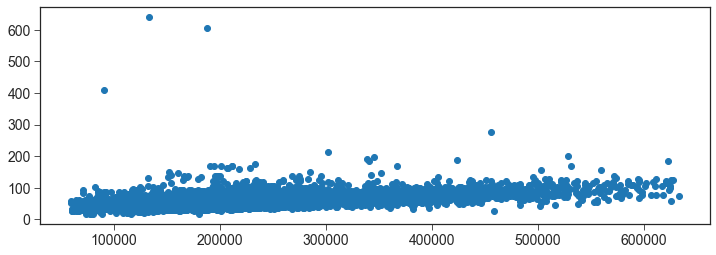

In [37]:
plt.rcParams['figure.figsize']=(12, 4)
plt.scatter(Cls.target,Cls.train['Square'])

площадь больше 400 уменьшаем в 10 раз и меняем местами где общая<жилой

In [38]:
Cls.d(1,Cls.train[Cls.train['Square']>400],
     Cls.test[Cls.test['Square']>400])

(3, 19)

(0, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
28,9,2.0,604.705972,NaN,10.0,17,18.0,1977,0.161532,0,0,25,5648,1,30.0,2,4,0,187717.242538
2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,0,0,26,3889,6,705.0,3,6,0,90470.430830


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,


In [39]:
Cls.train.loc[(Cls.train['Square']>400)&(Cls.train['Square']<Cls.train['LifeSquare']),['Square','LifeSquare']]=Cls.train.loc[(Cls.train['Square']>400)&(Cls.train['Square']<Cls.train['LifeSquare']),['LifeSquare','Square']].values
Cls.test.loc[(Cls.test['Square']>400)&(Cls.test['Square']<Cls.test['LifeSquare']),['Square','LifeSquare']]=Cls.test.loc[(Cls.test['Square']>400)&(Cls.test['Square']<Cls.test['LifeSquare']),['LifeSquare','Square']].values

Cls.train.loc[Cls.train['Square']>400,['Square','LifeSquare']]=Cls.train.loc[Cls.train['Square']>400,['Square','LifeSquare']]/10
Cls.test.loc[Cls.test['Square']>400,['Square','LifeSquare']]=Cls.test.loc[Cls.test['Square']>400,['Square','LifeSquare']]/10

In [40]:
Cls.h(1)

(3, 19)

(0, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
28,9,2.0,60.470597,NaN,10.0,17,18.0,1977,0.161532,0,0,25,5648,1,30.0,2,4,0,187717.242538
2307,102,1.0,41.063975,40.942518,10.0,4,4.0,2016,0.238617,0,0,26,3889,6,705.0,3,6,0,90470.430830


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,


жилая площадь несоразмерна с общей в 100 раз

In [41]:
Cls.d(1,Cls.train[(Cls.train['LifeSquare']<8)&((Cls.train['LifeSquare']*100)<Cls.train['Square'])]
     ,Cls.test[(Cls.test['LifeSquare']<8)&((Cls.test['LifeSquare']*100)<Cls.test['Square'])])

(2, 19)

(2, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
4378,27,3.0,106.958871,0.641822,11.0,17,0.0,2018,0.072158,0,0,2,629,1,NaN,0,0,1,337299.867936
13491,0,1.0,38.178277,0.370619,8.0,19,17.0,2016,0.006076,0,0,30,5285,0,645.0,6,6,0,105134.286994


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
6553,34,5.0,122.375273,0.333490,12.0,9,0.0,1977,0.069753,0,0,53,13670,4,NaN,1,11,0
6406,27,2.0,66.469510,0.567267,8.0,4,0.0,2018,0.017647,0,0,2,469,0,NaN,0,0,0


In [42]:
Cls.train.loc[(Cls.train['LifeSquare']<8)&((Cls.train['LifeSquare']*100)<Cls.train['Square']),'LifeSquare']=Cls.train.loc[(Cls.train['LifeSquare']<8)&((Cls.train['LifeSquare']*100)<Cls.train['Square']),'LifeSquare']*100
Cls.test.loc[(Cls.test['LifeSquare']<8)&((Cls.test['LifeSquare']*100)<Cls.test['Square']),'LifeSquare']=Cls.test.loc[(Cls.test['LifeSquare']<8)&((Cls.test['LifeSquare']*100)<Cls.test['Square']),'LifeSquare']*100

In [43]:
#Cls.train.loc[(Cls.train['LifeSquare']<8)&((Cls.train['LifeSquare']*100)<Cls.train['Square']),'LifeSquare']=Cls.train.loc[(Cls.train['LifeSquare']<8)&((Cls.train['LifeSquare']*100)<Cls.train['Square'])].apply(ax1,args=('LifeSquare',1),axis=1)
#Cls.test.loc[(Cls.test['LifeSquare']<8)&((Cls.test['LifeSquare']*100)<Cls.test['Square']),'LifeSquare']=Cls.test.loc[(Cls.test['LifeSquare']<8)&((Cls.test['LifeSquare']*100)<Cls.test['Square'])].apply(ax1,args=('LifeSquare',1),axis=1)

In [44]:
Cls.h(1)

(2, 19)

(2, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
4378,27,3.0,106.958871,64.182211,11.0,17,0.0,2018,0.072158,0,0,2,629,1,NaN,0,0,1,337299.867936
13491,0,1.0,38.178277,37.061942,8.0,19,17.0,2016,0.006076,0,0,30,5285,0,645.0,6,6,0,105134.286994


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
6553,34,5.0,122.375273,33.348994,12.0,9,0.0,1977,0.069753,0,0,53,13670,4,NaN,1,11,0
6406,27,2.0,66.469510,56.726699,8.0,4,0.0,2018,0.017647,0,0,2,469,0,NaN,0,0,0


In [45]:
Cls.d(1,Cls.train[(Cls.train['KitchenSquare']<5)&(Cls.train['Square']>40)],
Cls.test[(Cls.test['KitchenSquare']<5)&(Cls.test['Square']>40)])

(27, 19)

(14, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
35,7,2.0,43.948288,28.578213,4.0,6,5.0,1964,0.130618,0,0,39,10418,9,900.0,1,9,0,180923.169520
7196,8,2.0,45.263168,31.251545,4.0,9,9.0,1973,0.458174,0,1,26,4439,1,1130.0,1,5,0,204126.847689


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10051,46,2.0,45.777067,27.745856,4.0,2,5.0,1967,0.000000,0,0,47,11319,0,1145.0,3,5,0
90,51,3.0,75.401754,52.987524,4.0,2,6.0,1931,0.015017,0,0,17,3079,59,2890.0,0,8,0


In [46]:
Cls.train.loc[(Cls.train['KitchenSquare']<5)&(Cls.train['Square']>40),'KitchenSquare']=Cls.train.loc[(Cls.train['KitchenSquare']<5)&(Cls.train['Square']>40)].apply(ax1,args=('KitchenSquare',1),axis=1)
Cls.test.loc[(Cls.test['KitchenSquare']<5)&(Cls.test['Square']>40),'KitchenSquare']=Cls.test.loc[(Cls.test['KitchenSquare']<5)&(Cls.test['Square']>40)].apply(ax1,args=('KitchenSquare',1),axis=1)

In [47]:
Cls.h(1)

(27, 19)

(14, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
35,7,2.0,43.948288,28.578213,7.0,6,5.0,1964,0.130618,0,0,39,10418,9,900.0,1,9,0,180923.169520
7196,8,2.0,45.263168,31.251545,6.0,9,9.0,1973,0.458174,0,1,26,4439,1,1130.0,1,5,0,204126.847689


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10051,46,2.0,45.777067,27.745856,6.0,2,5.0,1967,0.000000,0,0,47,11319,0,1145.0,3,5,0
90,51,3.0,75.401754,52.987524,10.0,2,6.0,1931,0.015017,0,0,17,3079,59,2890.0,0,8,0


обработка количества комнат

In [48]:
Cls.ctn('Rooms')

19.0       1
17.0       1
10.0       2
6.0        3
0.0       10
5.0       25
4.0      240
3.0     3334
1.0     5474
2.0     5910
Name: Rooms, dtype: int64

In [49]:
Cls.d(1,Cls.train[(Cls.train['Rooms']>5)],
      Cls.test[(Cls.test['Rooms']>5)])

(4, 19)

(3, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,0,0,74,19083,2,NaN,5,15,0,317265.323792
8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,0,0,1,264,0,NaN,0,1,0,78364.616704


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10793,23,6.0,110.750226,NaN,11.0,2,2.0,2015,0.014073,0,0,2,475,0,NaN,0,0,0
4058,27,6.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,0,0,53,14892,4,NaN,1,4,0


In [50]:
Cls.train.loc[(Cls.train['Rooms']>5),'Rooms']=Cls.train.loc[(Cls.train['Rooms']>5)].apply(ax1,args=('Rooms',0), axis=1)
Cls.test.loc[(Cls.test['Rooms']>5),'Rooms']=Cls.test.loc[(Cls.test['Rooms']>5)].apply(ax1,args=('Rooms',0), axis=1)

not found median. index: 4058


In [51]:
Cls.test.loc[Cls.test.index==4058,'Rooms']=5

In [52]:
Cls.h(1)

(4, 19)

(3, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
5927,57,2.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,0,0,74,19083,2,NaN,5,15,0,317265.323792
8491,1,1.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,0,0,1,264,0,NaN,0,1,0,78364.616704


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10793,23,3.0,110.750226,NaN,11.0,2,2.0,2015,0.014073,0,0,2,475,0,NaN,0,0,0
4058,27,5.0,223.453689,104.113552,16.0,2,2.0,2017,0.041116,0,0,53,14892,4,NaN,1,4,0


In [53]:
Cls.d(1,Cls.train[(Cls.train['Rooms']==0)],
      Cls.test[(Cls.test['Rooms']==0)])

(8, 19)

(2, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
12638,27,0.0,138.427694,136.215499,14.0,4,3.0,2016,0.075424,0,0,11,3097,0,NaN,0,0,0,268394.744389
7917,27,0.0,212.932361,211.231125,17.5,2,3.0,2008,0.211401,0,0,9,1892,0,NaN,0,1,0,302211.260887


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
3343,58,0.0,116.824201,113.692424,12.0,3,3.0,1977,0.437885,0,0,23,5735,3,1084.0,0,5,0
10729,27,0.0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,0,0,2,469,0,NaN,0,0,0


In [54]:
Cls.train.loc[(Cls.train['Rooms']==0),'Rooms']=Cls.train.loc[(Cls.train['Rooms']==0)].apply(ax1,args=('Rooms',0), axis=1)
Cls.test.loc[(Cls.test['Rooms']==0),'Rooms']=Cls.test.loc[(Cls.test['Rooms']==0)].apply(ax1,args=('Rooms',0), axis=1)

In [55]:
Cls.h(1)

(8, 19)

(2, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
12638,27,3.0,138.427694,136.215499,14.0,4,3.0,2016,0.075424,0,0,11,3097,0,NaN,0,0,0,268394.744389
7917,27,4.5,212.932361,211.231125,17.5,2,3.0,2008,0.211401,0,0,9,1892,0,NaN,0,1,0,302211.260887


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
3343,58,3.0,116.824201,113.692424,12.0,3,3.0,1977,0.437885,0,0,23,5735,3,1084.0,0,5,0
10729,27,3.0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,0,0,2,469,0,NaN,0,0,0


In [56]:
#Cls.d(1,Cls.train[(Cls.train['Rooms']>3)&(Cls.train['Square']<80)],
#      Cls.test[(Cls.test['Rooms']>3)&(Cls.test['Square']<80)])

In [57]:
#Cls.train.loc[(Cls.train['Rooms']<3)&(Cls.train['Square']>100),'Rooms']=Cls.train.loc[(Cls.train['Rooms']<3)&(Cls.train['Square']>100)].apply(ax1,args=('Rooms',1), axis=1)
#Cls.test.loc[(Cls.test['Rooms']<3)&(Cls.test['Square']>100),'Rooms']=Cls.test.loc[(Cls.test['Rooms']<3)&(Cls.test['Square']>100)].apply(ax1,args=('Rooms',1), axis=1)
#Cls.train.loc[(Cls.train['Rooms']>3)&(Cls.train['Square']<80),'Rooms']=Cls.train.loc[(Cls.train['Rooms']>3)&(Cls.train['Square']<80)].apply(ax1,args=('Rooms',1), axis=1)
#Cls.test.loc[(Cls.test['Rooms']>3)&(Cls.test['Square']<80),'Rooms']=Cls.test.loc[(Cls.test['Rooms']>3)&(Cls.test['Square']<80)].apply(ax1,args=('Rooms',1), axis=1)

In [58]:
#Cls.h(1)

заполняем жилую площадь где ее нет на общую - площадь кухни

In [59]:
Cls.train.loc[Cls.train['LifeSquare'].isna(),'LifeSquare']=Cls.train.loc[Cls.train['LifeSquare'].isna(),'Square']-Cls.train.loc[Cls.train['LifeSquare'].isna(),'KitchenSquare']-2
Cls.test.loc[Cls.test['LifeSquare'].isna(),'LifeSquare']=Cls.test.loc[Cls.test['LifeSquare'].isna(),'Square']-Cls.test.loc[Cls.test['LifeSquare'].isna(),'KitchenSquare']-2

In [60]:
Cls.d(1,Cls.train[(Cls.train['LifeSquare']<8)&((Cls.train['LifeSquare']*10+Cls.train['KitchenSquare'])<Cls.train['Square'])]
     ,Cls.test[(Cls.test['LifeSquare']<8)&((Cls.test['LifeSquare']*10+Cls.test['KitchenSquare'])<Cls.test['Square'])])

(148, 19)

(80, 18)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
4280,34,2.0,61.334968,4.091945,8.0,26,1.0,2014,0.069753,0,0,53,13670,4,NaN,1,11,0,286564.441972
12613,6,2.0,65.496674,5.589324,8.0,5,17.0,1977,0.243205,0,0,5,1564,0,540.0,0,0,0,180727.643541


,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
3495,27,3.0,82.652818,5.690155,10.0,4,17.0,2015,0.072158,0,0,2,629,1,NaN,0,0,1
9205,120,2.0,85.911827,4.188395,10.0,5,1.0,2016,0.341072,0,0,27,5664,48,2300.0,3,11,0


In [61]:
Cls.train.loc[(Cls.train['LifeSquare']<8)&((Cls.train['LifeSquare']*10+Cls.train['KitchenSquare'])<Cls.train['Square']),'LifeSquare']=Cls.train.loc[(Cls.train['LifeSquare']<8)&((Cls.train['LifeSquare']*10+Cls.train['KitchenSquare'])<Cls.train['Square'])].apply(ax1,args=('LifeSquare',1), axis=1)
Cls.test.loc[(Cls.test['LifeSquare']<8)&((Cls.test['LifeSquare']*10+Cls.test['KitchenSquare'])<Cls.test['Square']),'LifeSquare']=Cls.test.loc[(Cls.test['LifeSquare']<8)&((Cls.test['LifeSquare']*10+Cls.test['KitchenSquare'])<Cls.test['Square'])].apply(ax1,args=('LifeSquare',1), axis=1)

In [62]:
Cls.train.loc[(Cls.train['Square']-Cls.train['LifeSquare']-Cls.train['KitchenSquare']<1),'LifeSquare']=Cls.train.loc[(Cls.train['Square']-Cls.train['LifeSquare']-Cls.train['KitchenSquare']<1),'Square']-Cls.train.loc[(Cls.train['Square']-Cls.train['LifeSquare']-Cls.train['KitchenSquare']<1),'KitchenSquare']
Cls.test.loc[(Cls.test['Square']-Cls.test['LifeSquare']-Cls.test['KitchenSquare']<1),'LifeSquare']=Cls.test.loc[(Cls.test['Square']-Cls.test['LifeSquare']-Cls.test['KitchenSquare']<1),'Square']-Cls.test.loc[(Cls.test['Square']-Cls.test['LifeSquare']-Cls.test['KitchenSquare']<1),'KitchenSquare']

где этаж 0 замена на медиану и меняем местами где этажность дома меньше этажа 

In [63]:
Cls.train['HouseFloor_outlier']=0
Cls.train.loc[(Cls.train['HouseFloor']==0), 'HouseFloor_outlier'] = 1
Cls.train.loc[Cls.train['Floor'] > Cls.train['HouseFloor'], 'HouseFloor_outlier'] = 1
Cls.train.loc[(Cls.train['Floor'] > Cls.train['HouseFloor'])&(Cls.train['HouseFloor']!=0), ['Floor','HouseFloor']] = Cls.train.loc[(Cls.train['Floor'] > Cls.train['HouseFloor'])&(Cls.train['HouseFloor']!=0), ['HouseFloor','Floor']].values
Cls.train.loc[Cls.train['HouseFloor'] == 0, 'HouseFloor'] = Cls.train.loc[Cls.train['HouseFloor'] == 0].apply(ax1,args=('HouseFloor',0,'Floor'), axis=1)

Cls.test['HouseFloor_outlier']=0
Cls.test.loc[(Cls.test['HouseFloor']==0), 'HouseFloor_outlier'] = 1
Cls.test.loc[Cls.test['Floor'] > Cls.test['HouseFloor'], 'HouseFloor_outlier'] = 1
Cls.test.loc[(Cls.test['Floor'] > Cls.test['HouseFloor'])&(Cls.test['HouseFloor']!=0), ['Floor','HouseFloor']] = Cls.test.loc[(Cls.test['Floor'] > Cls.test['HouseFloor'])&(Cls.test['HouseFloor']!=0), ['HouseFloor','Floor']].values
Cls.test.loc[Cls.test['HouseFloor'] == 0, 'HouseFloor'] = Cls.test.loc[Cls.test['HouseFloor'] == 0].apply(ax1,args=('HouseFloor',0,'Floor'), axis=1)

In [64]:
#Cls.train.loc[(Cls.train['LifeSquare']+Cls.train['KitchenSquare']<Cls.train['Square']*1.6),'LifeSquare']=Cls.train.loc[(Cls.train['LifeSquare']+Cls.train['KitchenSquare']<Cls.train['Square']*1.6),'Square']-Cls.train.loc[(Cls.train['LifeSquare']+Cls.train['KitchenSquare']<Cls.train['Square']*1.6),'KitchenSquare']
#Cls.test.loc[(Cls.test['LifeSquare']+Cls.test['KitchenSquare']<Cls.test['Square']*1.6),'LifeSquare']=Cls.test.loc[(Cls.test['LifeSquare']+Cls.test['KitchenSquare']<Cls.test['Square']*1.6),'Square']-Cls.test.loc[(Cls.test['LifeSquare']+Cls.test['KitchenSquare']<Cls.test['Square']*1.6),'KitchenSquare']

In [65]:
class NewGen():
 
    def __init__(self):
        self.df_aggs={}
        self.defaults={}

    def gen_val(self, group_bys, agg_col, train):

        new_col_name = agg_col + '_By_' + '_AND_'.join(group_bys)
        
        if self.df_aggs.get(new_col_name):
            print('Error!!!')
            return
        
        self.df_aggs[new_col_name] = {}
        self.df_aggs[new_col_name]['df'] = train.groupby(group_bys, as_index=False).agg({agg_col: 'median'})\
                            .rename(columns = {agg_col : new_col_name})
        self.df_aggs[new_col_name]['default']=0
        self.df_aggs[new_col_name]['on']=group_bys

    def merge(self,df,val,ons):# ons ['DistrictId', 'Rooms']
        return df.merge(val, on = ons, how = 'left', suffixes=(False, False)).set_index(df.index)

    def fit(self, train, target=None):
          
        df = train.copy()
        
        df = self.house_flor_to_cat(df)
        df = self.floor_to_cat(df)
        df = self.year_to_cat(df)

        # DistrictID
        district = df['DistrictId'].value_counts()
        district = district[district > 50]  
        
        self.districts_pops = dict(district)

        df = self.get_district_pop(df)

        # медианная стоимость квадратного метра в зависимости от района
 
        self.gen_val(['DistrictId'], 'PriceM2', df)

        # медианная стоимость квадратного метра в зависимости от возраста дома
        self.gen_val(['HouseYear'], 'PriceM2', df)
            
        # медианная стоимость квадратного метра в зависимости от Ecology_1
        self.gen_val(['Ecology_1'], 'PriceM2', df)
            
        # медианная стоимость квадратного метра в зависимости от Social_1
        self.gen_val(['Social_1'], 'PriceM2', df)
            
        # медианная стоимость квадратного метра в зависимости от Shops_1
        self.gen_val(['Shops_1'], 'PriceM2', df)
        
        #в зависимости категории года постройки и этажа
        self.gen_val(['Year_cat', 'Floor_cat'], 'Price', df)
      
        #в зависимости категории года постройки и этажа
        self.gen_val(['DistrictId', 'Rooms'], 'Price', df)
 
    def transform(self, df):
        
        df = df.copy()

        self.get_district_pop(df)

        df = self.floor_to_cat(df)
        df = self.year_to_cat(df)
        df = self.house_flor_to_cat(df)
        
        for new_col_name, vals in self.df_aggs.items():
            df = self.merge(df,vals['df'],vals['on'])

        return df
    
    def get_district_pop(self, df):
        
        df['DistrictId_pop'] = df['DistrictId'].map(self.districts_pops)
        df['New_district'] = 0
        df.loc[df['DistrictId_pop'].isna(),  ['New_district','DistrictId']] = (1,999)
        
        df['DistrictId_pop'].fillna(5, inplace=True)
        
        return df
    
    def house_flor_to_cat(self, df):
        
        df['HouseFloor_cat'] = np.nan
        
        df.loc[df['HouseFloor'] < 3, 'HouseFloor_cat'] = 1  
        df.loc[(df['HouseFloor'] >= 3) & (df['HouseFloor'] <= 5), 'HouseFloor_cat'] = 2
        df.loc[(df['HouseFloor'] > 5) & (df['HouseFloor'] <= 9), 'HouseFloor_cat'] = 3
        df.loc[(df['HouseFloor'] > 9) & (df['HouseFloor'] <= 15), 'HouseFloor_cat'] = 4
        df.loc[df['HouseFloor'] > 15, 'HouseFloor_cat'] = 5
 
        return df
    
    def floor_to_cat(self, df):
        
        df['Floor_cat'] = np.nan
        
        df.loc[df['Floor'] < 3, 'Floor_cat'] = 1  
        df.loc[(df['Floor'] >= 3) & (df['Floor'] <= 7), 'Floor_cat'] = 4
        df.loc[(df['Floor'] > 7) & (df['Floor'] <= 11), 'Floor_cat'] = 5
        df.loc[(df['Floor'] > 11) & (df['Floor'] <= 15), 'Floor_cat'] = 2
        df.loc[df['Floor'] > 15, 'Floor_cat'] = 3
    
        return df

    def year_to_cat(self, df):
        
        df['Year_cat'] = np.nan
        
        df.loc[df['HouseYear'] < 1941, 'Year_cat'] = 1
        df.loc[(df['HouseYear'] >= 1941) & (df['HouseYear'] <= 1945), 'Year_cat'] = 2
        df.loc[(df['HouseYear'] > 1945) & (df['HouseYear'] <= 1980), 'Year_cat'] = 3
        df.loc[(df['HouseYear'] > 1980) & (df['HouseYear'] <= 2000), 'Year_cat'] = 4
        df.loc[(df['HouseYear'] > 2000) & (df['HouseYear'] <= 2010), 'Year_cat'] = 5
        df.loc[(df['HouseYear'] > 2010), 'Year_cat'] = 6
            
        return df

Генерация новых признаков

In [66]:
Cls.uniq('DistrictId')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212]
not in train:
[198, 203, 204, 206, 210, 211, 212]

In [67]:
Cls.test[Cls.test['DistrictId'].isin([198, 203, 204, 206, 210, 211, 212])]['DistrictId'].value_counts()

206    2
204    1
203    1
198    1
212    1
211    1
210    1
Name: DistrictId, dtype: int64

In [68]:
Cls.train['PricePerRoom'] = Cls.train['Price'] / Cls.train['Rooms']
Cls.train['PriceM2'] = Cls.train['Price'] / Cls.train['Square']

In [69]:
features = NewGen()

features.fit(Cls.train)

Cls.train=features.transform(Cls.train)
Cls.test=features.transform(Cls.test)

In [70]:
Cls.isna()

Healthcare_1    4798
dtype: int64

Healthcare_1                     2377
PriceM2_By_HouseYear               12
PriceM2_By_Ecology_1                5
Price_By_DistrictId_AND_Rooms      11
dtype: int64

In [71]:
Cls.test.loc[Cls.test['PriceM2_By_HouseYear'].isna(),'PriceM2_By_HouseYear']=Cls.test[Cls.test['PriceM2_By_HouseYear'].isna()].apply(ax1,args=('PriceM2_By_HouseYear',0,'HouseYear'), axis=1)
Cls.test.loc[Cls.test['PriceM2_By_Ecology_1'].isna(),'PriceM2_By_Ecology_1']=Cls.test[Cls.test['PriceM2_By_Ecology_1'].isna()].apply(ax1,args=('PriceM2_By_Ecology_1',0,'Ecology_1'), axis=1)
Cls.test.loc[Cls.test['Price_By_DistrictId_AND_Rooms'].isna(),'Price_By_DistrictId_AND_Rooms']=Cls.test[Cls.test['Price_By_DistrictId_AND_Rooms'].isna()].apply(ax1,args=('Price_By_DistrictId_AND_Rooms',0,'Rooms'), axis=1)

In [72]:
#display(Cls.test[Cls.test.index.isin([15834,6495,7413,6074,8593,5480, 3726, 5118, 9501, 16379, 11269, 732, 12316, 6204, 9111, 7478, 9739,117, 15858, 7135, 10164, 13399, 14274, 4058, 8638, 8982, 8260,2196, 4141])])

In [73]:
feature_names = [
#    'DistrictId',
    'Rooms',
    'Square',
    'LifeSquare',
    'KitchenSquare',
    'Floor',
    'HouseFloor',
    'HouseYear',
    'Ecology_1',
#    'Ecology_2',
#    'Ecology_3',
    'Social_1',
    'Social_2',
    'Social_3',
#    'Healthcare_1',
    'Helthcare_2',
    'Shops_1',
#    'Shops_2',
#    'Price',
    'HouseFloor_outlier',
#    'PricePerRoom',
#    'PriceM2',
    'DistrictId_pop',
    'New_district',
    'Floor_cat',
    'Year_cat',
    'HouseFloor_cat',
#    'PriceM2_By_DistrictId',
    'PriceM2_By_HouseYear',
    'PriceM2_By_Ecology_1',
    'PriceM2_By_Social_1',
    'PriceM2_By_Shops_1',
#    'Price_By_Year_cat_AND_Floor_cat',
#    'Price_By_DistrictId_AND_Rooms'
]

In [74]:
X = Cls.train[feature_names]
y = Cls.target.values.ravel()

X_test = Cls.test[feature_names]

forest = RandomForestRegressor(max_depth=18, 
                               max_features=5, 
                               n_estimators=400,
                               random_state=42)

In [75]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)
cv_score=cross_val_score(forest, X, y, scoring='r2', cv=kf)

print(f'R2 {cv_score.mean():.5f} +- {cv_score.std():.5f}')

R2 0.75889 +- 0.01321


In [76]:
def tester(model,start,end,X,y):
    max_depth_values = np.arange(start, end)
    accuracy = []

    for i, value in enumerate(max_depth_values):
        clf = RandomForestRegressor(max_depth=value,max_features=5, 
                                   n_estimators=400,
                                   random_state=42)
        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        cv_score = cross_val_score(clf, X, y, scoring='r2', cv=kf)
        accuracy.append(cv_score.mean())

    plt.rcParams['figure.figsize'] = 6, 4
    plt.plot(max_depth_values, accuracy)
    plt.xlabel('Значение параметра max_depth')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.show()

#tester(forest,18,26,X,y)

In [77]:
params = {
    'n_estimators': [400],
    'max_depth': [18,19,20,21,22],
    'max_features': [5,6,7]
}

#forest_grid = GridSearchCV(forest, params, scoring='r2', 
#                  cv=KFold(n_splits=10, random_state=42, shuffle=True), 
#                  n_jobs=-1)
#forest_grid.fit(X, y)
#print(forest_grid.best_params_)
#print('R2 на train: {:.5f}'.format(forest_grid.best_score_))

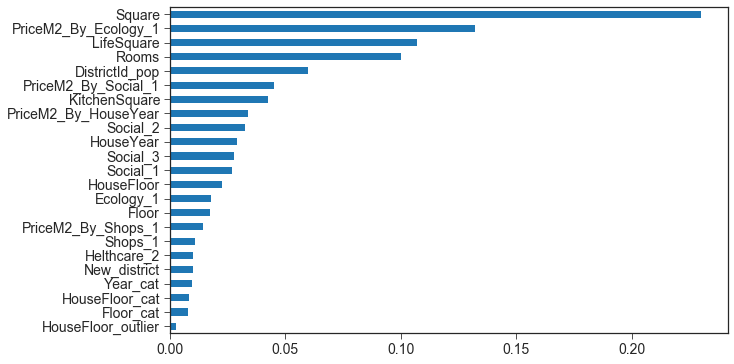

In [78]:
forest.fit(X, y)
importances = forest.feature_importances_
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.sort_values(ascending=True, inplace=True)

feat_importances.plot(kind='barh', figsize=(10, 6));

In [79]:
y_pred = forest.predict(X_test)

preds = pd.DataFrame()
preds['Id'] = Cls.preds_index
preds['Price'] = y_pred

In [80]:
preds.to_csv('ArtemK_submission.csv', index=False)